<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/CT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Edited: Sama
# Spleen 3D Regression with MONAI



## Setup environment

In [12]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import torch.nn as nn
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

# compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# data_dir = os.path.join(root_dir, "Task09_Spleen")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

2023-12-13 08:30:09.004308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 08:30:09.004371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 08:30:09.004416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 08:30:10.096224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set MSD Spleen dataset path

In [14]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "label": img} for img in train_images]
# make input smaller to save time for practing stage:
train_files, val_files = data_dicts[:9], data_dicts[-9:]

set_determinism(seed=0)

In [15]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image", "label"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


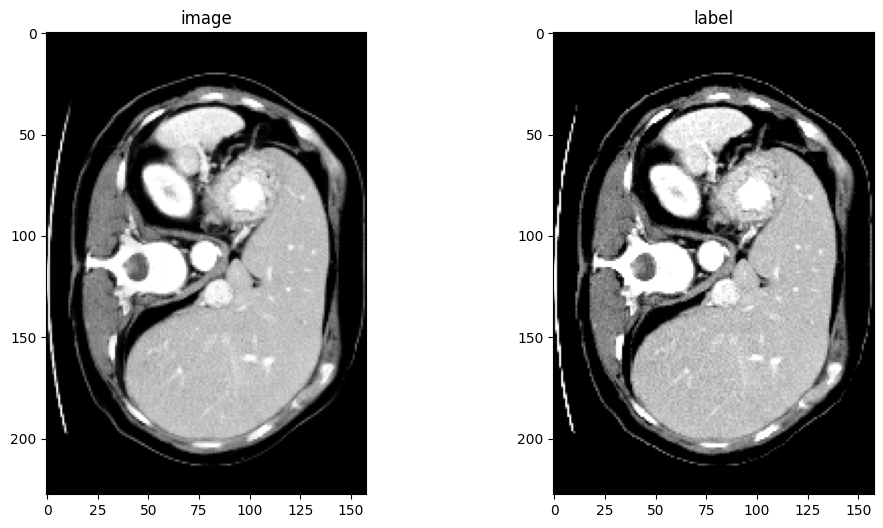

In [16]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80], cmap="gray")
plt.show()

## Define CacheDataset and DataLoader

In [17]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:32<00:00,  3.56s/it]


## Create Model, Loss, Optimizer

In [18]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,  # Single channel for regression output
    channels=(16, 32, 64, 128, 256),
    act=(nn.ReLU, {"inplace": True}),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
# import torch
# from monai.networks.nets import UNet
# from monai.networks.layers import Norm

# class RegressionUNet(UNet):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#     def forward(self, x):
#         x = super().forward(x)
#         # Apply ReLU activation in the last layer
#         return torch.relu(x)

# # Initialize your custom model
# model = RegressionUNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,  # Single channel for regression output
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)


loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [19]:

max_epochs = 10
val_interval = 2
best_metric = float('inf')  # Initialize with infinity, since lower MSE is better
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # Compute MSE for current iteration
                val_loss += loss_function(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}"
                f"\nbest val loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/10
1/4, train_loss: 391372.7500
2/4, train_loss: 272385.0312
3/4, train_loss: 115102.5391
4/4, train_loss: 201434.3750
5/4, train_loss: 242209.4062
epoch 1 average loss: 244500.8203
----------
epoch 2/10
1/4, train_loss: 178252.0312
2/4, train_loss: 208176.0000
3/4, train_loss: 210245.7812
4/4, train_loss: 262060.7031
5/4, train_loss: 102483.2969
epoch 2 average loss: 192243.5625
saved new best metric model
current epoch: 2 current val loss: 0.0945
best val loss: 0.0945 at epoch: 2
----------
epoch 3/10
1/4, train_loss: 186271.3906
2/4, train_loss: 194104.4219
3/4, train_loss: 177801.1250
4/4, train_loss: 278346.0312
5/4, train_loss: 332777.3125
epoch 3 average loss: 233860.0562
----------
epoch 4/10
1/4, train_loss: 167821.2656
2/4, train_loss: 178955.8906
3/4, train_loss: 133561.0312
4/4, train_loss: 238031.9219
5/4, train_loss: 226777.7500
epoch 4 average loss: 189029.5719
saved new best metric model
current epoch: 4 current val loss: 0.0865
best val loss: 0.0865 

In [20]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0865 at epoch: 4


## Plot the loss and metric

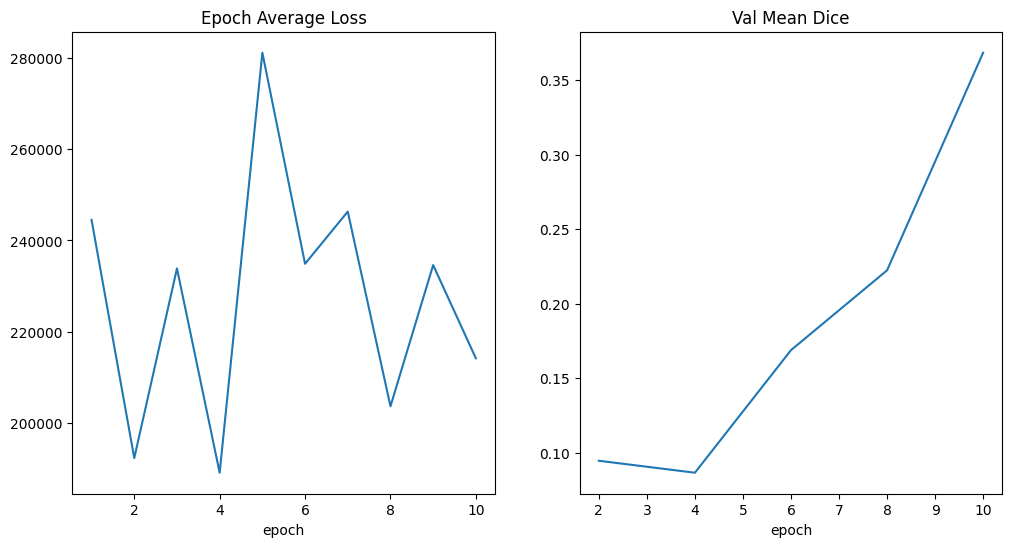

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

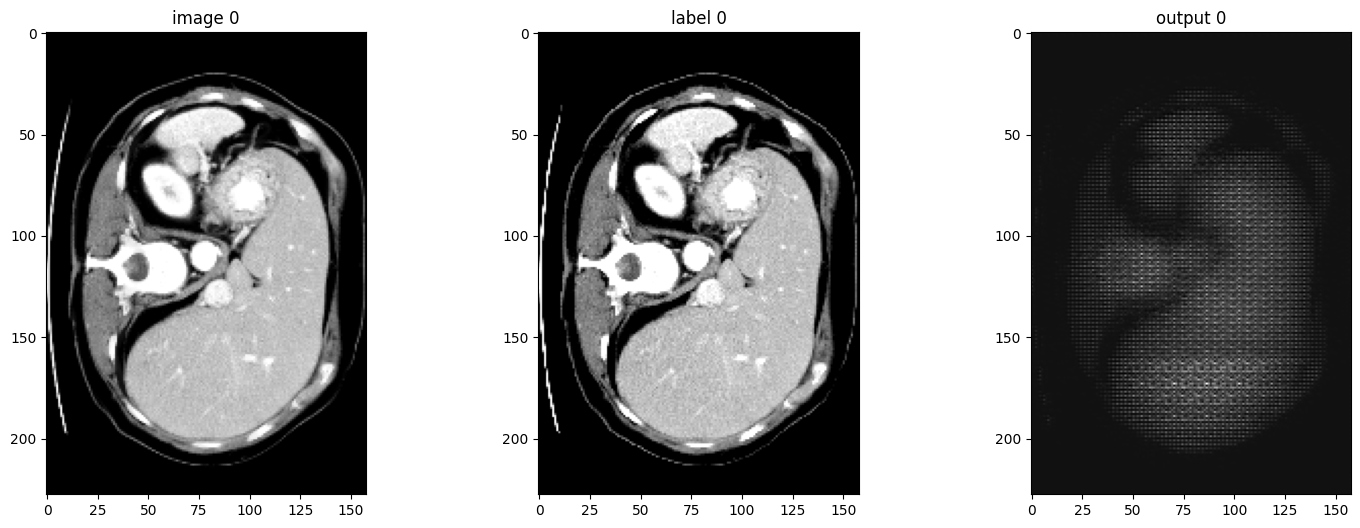

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output_slice = val_outputs.detach().cpu()[0, 0, :, :, 80]
        # Assuming the output values are normalized, adjust if not
        plt.imshow(output_slice, cmap="gray")
        plt.show()
        if i == 0:
            break


---------------------

In [23]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "label": img} for img in train_images]
# make input smaller to save time for practing stage:
train_files, val_files = data_dicts[:9], data_dicts[-9:]

set_determinism(seed=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest"))
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest"))
    ]
)

# # Data loaders
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

from monai.data import pad_list_data_collate

# Data loaders with pad_list_data_collate
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=pad_list_data_collate)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=pad_list_data_collate)




Loading dataset: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


In [25]:

# Model setup
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    # Ensure the last layer uses ReLU if needed
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)